## Model with polynomial features

In [1]:
#pip install scikit-learn==0.23.2

In [2]:
#import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Columns to be considered

num_col = {'Bsmt Cond',
 'Bsmt Exposure',
 'Bsmt Qual',
 'BsmtFin SF 1',
 'Exter Cond',
 'Exter Qual',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Garage Cond',
 'Garage Qual',
 'Gr Liv Area',
 'Heating QC',
 'Kitchen Qual',
 'Mas Vnr Area',
 'Open Porch SF',
 'Overall Qual',
 'Total_area',
 'Wood Deck SF',
 'age_since_built',
 'lot_frontage_imputed'}

cat_to_num = {'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
    'Bsmt Exposure', 'Heating QC',
    'Kitchen Qual', 'Garage Qual', 'Garage Cond'}
     

cat_col = {'Bldg Type',
 'Foundation',
 'Street',
 'Central Air',
 'Electrical',
 'MS Zoning',
 'Land Contour',
 'Mas Vnr Type',
 'Heating',
 'Paved Drive',
 'Neighborhood'
          }

In [4]:
def cleaning_data(df):
    
    # 1. Drop most missing columns 
    df = df.drop(
    columns=['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'])

    # 2. Impute lot frontage
    from sklearn.linear_model import LinearRegression
    X_lot = df[df['Lot Frontage'] > 0][['1st Flr SF','Lot Area']]
    y_lot = df[df['Lot Frontage'] > 0]['Lot Frontage']
    lot_model = LinearRegression()
    lot_model.fit(X_lot,y_lot)
    
    lot_frontage_imputed = []
    for i in range(len(df)):
        if df.loc[i,'Lot Frontage'] > 0:
            lot_frontage_imputed.append(df.loc[i,'Lot Frontage'])
        else:
            lot_frontage_imputed.append(lot_model.predict([df.loc[i,['1st Flr SF','Lot Area']]])[0])

    df['lot_frontage_imputed'] = lot_frontage_imputed
    df = df.drop(columns = ['Lot Frontage'])
    
    #Garage Imputation

    df['Garage Yr Blt'] = df['Garage Yr Blt'].map(lambda x: x if x > 0 else 0)
    df['Garage Finish'] = df['Garage Finish'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Qual'] = df['Garage Qual'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Cond'] = df['Garage Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Type'] = df['Garage Type'].map(lambda x: x if type(x) == str else 'NO')
    
    #Basement imputation
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Cond'] = df['Bsmt Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Qual'] = df['Bsmt Qual'].map(lambda x: x if type(x) == str else 'NO')
    
    #Mansory type and area
    df['Mas Vnr Type'] = df['Mas Vnr Type'].map(lambda x: x if type(x) == str else 'NO')
    df['Mas Vnr Area'] = df['Mas Vnr Area'].map(lambda x: x if x > 0 else 0)
    
    #Electrical Imputation
    df['Electrical'] = df['Electrical'].map(lambda x: x if type(x) == str else df['Electrical'].mode()[0])
    #Drop other observation containing Null
    df = df.dropna()
    
    return df

#Feature Engieering Function
def feat_eng(df):
    df['age_since_built'] = df['Yr Sold'] - df['Year Built']
    df['Total_area'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
    return df
#Converted OrdiNal Categorical columns to Numerical 
def cat2num(df):
    for col in cat_to_num:
        df[col] = df[col].map(to_num)
    return df

#Conversion function
def to_num(val):
    if val == 'Ex':
        return 5
    elif val == 'Gd':
        return 4
    elif val == 'TA' or val == 'Av':
        return 3
    elif val == 'Fa' or val == 'Mn':
        return 2
    elif val == 'Po' or val == 'No':
        return 1
    elif val == 'NO':
        return 0



In [97]:
def prep_poly(df, train_df):
    """
    df = DataFrame to be transformed
    train_df = cleaned training set
    """

    #OneHotEncoding
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train_df[cat_col])
    df_encode = pd.DataFrame(encoder.transform(df[cat_col]),
                             columns=encoder.get_feature_names(
                                 df[cat_col].columns),
                             index=df.index)

    train_df_encode = pd.DataFrame(encoder.transform(train_df[cat_col]),
                                   columns=encoder.get_feature_names(
                                       train_df[cat_col].columns),
                                   index=train_df.index)

    #Applying Polynomial Features
    poly = PolynomialFeatures(degree=2, include_bias=False,interaction_only=True)
    df_withpoly = pd.DataFrame(
        poly.fit_transform(df[num_col]),
        columns=poly.get_feature_names(input_features=df[num_col].columns),
        index=df.index)

    train_df_withpoly = pd.DataFrame(
        poly.fit_transform(train_df[num_col]),
        columns=poly.get_feature_names(
            input_features=train_df[num_col].columns),
        index=train_df.index)

    #Merge with numerical attribute
    X_new = pd.concat([df_withpoly, df_encode], axis=1)
    X_train = pd.concat([train_df_withpoly, train_df_encode], axis=1)

    #Standardize
    ss = StandardScaler()
    ss.fit(X_train)

    X_new_scaled = ss.transform(X_new)
    X_new_scaled = pd.DataFrame(X_new_scaled,columns = X_new.columns)

    
    return X_new_scaled


#     return X_new_scaled

def prep(df, train_df):
    """
    df = DataFrame to be transformed
    train_df = cleaned training set
    """

    #OneHotEncoding
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train_df[cat_col])
    df_encode = pd.DataFrame(encoder.transform(df[cat_col]),
                             columns=encoder.get_feature_names(
                                 df[cat_col].columns),
                             index=df.index)

    train_df_encode = pd.DataFrame(encoder.transform(train_df[cat_col]),
                                   columns=encoder.get_feature_names(
                                       train_df[cat_col].columns),
                                   index=train_df.index)

#     #Applying Polynomial Features
#     poly = PolynomialFeatures(degree=2, include_bias=False)
#     df_withpoly = pd.DataFrame(
#         poly.fit_transform(df[num_col]),
#         columns=poly.get_feature_names(input_features=df[num_col].columns),
#         index=df.index)

#     train_df_withpoly = pd.DataFrame(
#         poly.fit_transform(train_df[num_col]),
#         columns=poly.get_feature_names(
#             input_features=train_df[num_col].columns),
#         index=train_df.index)

    #Merge with numerical attribute
    X_new = pd.concat([df[num_col], df_encode], axis=1)
    X_train = pd.concat([train_df[num_col], train_df_encode], axis=1)

    #Standardize
    ss = StandardScaler()
    ss.fit(X_train)

    X_new_scaled = ss.transform(X_new)
    X_new_scaled = pd.DataFrame(X_new_scaled,columns = X_new.columns)

    return X_new_scaled


#     return X_new_scaled

Preprocessing order
1. Cleaning
1. Feature engineering
1. cat_to_num
1. OneHotEncoding

In [6]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)
X_train = prep_poly(train,train)
y_train = train['SalePrice']

In [7]:
test = pd.read_csv('../datasets/test.csv')
test = cleaning_data(test)
test = feat_eng(test)
test = cat2num(test)
X_test = prep_poly(test,train)

## Model Training

### Instantiate

In [8]:
#MLR
lr = LinearRegression()

#Ridge LR
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=r_alphas,cv=5)

#Lasso LR
l_alphas = np.arange(0.001, 1, 0.01)
lasso_cv = LassoCV(alphas=l_alphas, max_iter=5000,cv=5)

#Elasticnet LR
l1_ratio = np.linspace(0, 1, 11)
enet_cv = ElasticNetCV(alphas=l_alphas, l1_ratio=l1_ratio, max_iter=5000,cv=5)

### Training

In [9]:
#MLR Fitting
lr.fit(X_train,y_train)

#RidgeLR Fitting
ridge_cv.fit(X_train,y_train)

#LassoLR Fitting
lasso_cv.fit(X_train,y_train)

#ElasticNetLR Fitting
enet_cv.fit(X_train,y_train)

ElasticNetCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
             cv=5,
             l1_ratio=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             max_iter=5000)

In [10]:
#RMSE on training set
print('Linear Regression')
print(metrics.mean_squared_error(y_train,lr.predict(X_train),squared = False),'\n')
print('Ridge Regression')
print(metrics.mean_squared_error(y_train,ridge_cv.predict(X_train),squared = False),'\n')
print('Lasso Regression')
print(metrics.mean_squared_error(y_train,lasso_cv.predict(X_train),squared = False),'\n')
print('ElasticNet Regression')
print(metrics.mean_squared_error(y_train,enet_cv.predict(X_train),squared = False),'\n')

Linear Regression
18987.03853600366 

Ridge Regression
20929.507734223145 

Lasso Regression
19080.018904268658 

ElasticNet Regression
21147.198945002267 



### Cross Validation

In [11]:
ridge = Ridge(alpha=ridge_cv.alpha_,max_iter=5000)
lasso = Lasso(alpha=lasso_cv.alpha_,max_iter=5000)
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_,max_iter=5000)

#Cross Validation RMSE
lr_cv_score = cross_val_score(
    lr, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1
ridge_cv_score = cross_val_score(
    ridge, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1
lasso_cv_score = cross_val_score(
    lasso, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1
enet_cv_score = cross_val_score(
    enet, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1

In [12]:
#Cross Validation RMSE
print('Linear Regression')
print(lr_cv_score,'\n')
print('Ridge Regression')
print(ridge_cv_score,'\n')
print('Lasso Regression')
print(lasso_cv_score,'\n')
print('ElasticNet Regression')
print(enet_cv_score,'\n')

Linear Regression
29876.54217796661 

Ridge Regression
25865.262899204117 

Lasso Regression
29783.91409191237 

ElasticNet Regression
25875.369076657753 



the Best model ranked by cross validation score is ElasticNet Regression

### Save model for later use

Since the ElasticNet model is the best option I have, I'll save and continue to develop on this model

In [13]:
from joblib import dump, load
dump(ridge, 'ridge_regressor.joblib')
dump(lasso, 'lasso_regressor.joblib')
dump(enet, 'enet_regressor.joblib') 

['enet_regressor.joblib']

## Baseline score

Establishing a baseline rmse by predicting mean for every observation

In [14]:
res = y_train - np.mean(y_train)
mse = np.sum(np.power(res,2)/len(y_train))
rmse = np.sqrt(mse)

In [15]:
rmse

79229.30771126608

Our model perform far better than the baseline RMSE

### Making prediction and submit the result!

In [16]:
enet.fit(X_train,y_train)
Polynomial_prediction = enet.predict(X_test)
Polynomial_submission = pd.DataFrame(Polynomial_prediction,
                                   index=test.Id,
                                   columns=['SalePrice'])
Polynomial_submission.to_csv('../Submission/Polynomial_submission.csv')

> ** As of 06/03/2021, the public score on Kaggle = 27930.67 **


## Further finetuning

### Remove Outliers in SalePrice (Worsen thae model performance on test set!)

In [17]:
#Add remove outliers step to preprocessing.
def cleaning_data(df):
    
    # 1. Drop most missing columns 
    df = df.drop(
    columns=['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'])

    # 2. Impute lot frontage
    from sklearn.linear_model import LinearRegression
    X_lot = df[df['Lot Frontage'] > 0][['1st Flr SF','Lot Area']]
    y_lot = df[df['Lot Frontage'] > 0]['Lot Frontage']
    lot_model = LinearRegression()
    lot_model.fit(X_lot,y_lot)
    
    lot_frontage_imputed = []
    for i in range(len(df)):
        if df.loc[i,'Lot Frontage'] > 0:
            lot_frontage_imputed.append(df.loc[i,'Lot Frontage'])
        else:
            lot_frontage_imputed.append(lot_model.predict([df.loc[i,['1st Flr SF','Lot Area']]])[0])

    df['lot_frontage_imputed'] = lot_frontage_imputed
    df = df.drop(columns = ['Lot Frontage'])
    
    #Garage Imputation

    df['Garage Yr Blt'] = df['Garage Yr Blt'].map(lambda x: x if x > 0 else 0)
    df['Garage Finish'] = df['Garage Finish'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Qual'] = df['Garage Qual'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Cond'] = df['Garage Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Garage Type'] = df['Garage Type'].map(lambda x: x if type(x) == str else 'NO')
    
    #Basement imputation
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(lambda x: x if type(x) == str else 'NO')
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Cond'] = df['Bsmt Cond'].map(lambda x: x if type(x) == str else 'NO')
    df['Bsmt Qual'] = df['Bsmt Qual'].map(lambda x: x if type(x) == str else 'NO')
    
    #Mansory type and area
    df['Mas Vnr Type'] = df['Mas Vnr Type'].map(lambda x: x if type(x) == str else 'NO')
    df['Mas Vnr Area'] = df['Mas Vnr Area'].map(lambda x: x if x > 0 else 0)
    
    #Electrical Imputation
    df['Electrical'] = df['Electrical'].map(lambda x: x if type(x) == str else df['Electrical'].mode()[0])
    #Drop other observation containing Null
    df = df.dropna()
    
    #Drop outliers
#     if df.shape[0] > 1000: #if df is training set
#         df = df[df['SalePrice'] < 400000]
    
    return df

### Run Recursive Feature Elimination on all categorical variables

In [18]:
#Columns to be considered

num_col = {'Bsmt Cond',
 'Bsmt Exposure',
 'Bsmt Qual',
 'BsmtFin SF 1',
 'Exter Cond',
 'Exter Qual',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Garage Cond',
 'Garage Qual',
 'Gr Liv Area',
 'Heating QC',
 'Kitchen Qual',
 'Mas Vnr Area',
 'Open Porch SF',
 'Overall Qual',
 'Total_area',
 'Wood Deck SF',
 'age_since_built',
 'lot_frontage_imputed'}

cat_to_num = {'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
    'Bsmt Exposure', 'Heating QC',
    'Kitchen Qual', 'Garage Qual', 'Garage Cond'}
     


cat_col = {'MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'}

cat_col = cat_col.difference(cat_to_num)

In [19]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)

# Define X,y
X_cat_only = train[cat_col]
y_cat_only = train['SalePrice']

ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_cat_only_enc = pd.DataFrame(ohc.fit_transform(X_cat_only),
                             columns=ohc.get_feature_names(
                                 X_cat_only.columns),
                             index=X_cat_only.index)

In [20]:
from sklearn.feature_selection import RFECV

In [21]:
# Loop until we get only less than 10 significant categorical feature
for alpha in range(1,10000,250):
    
    rfecv = RFECV(Lasso(alpha=alpha),step=1,cv=5,scoring = 'neg_root_mean_squared_error')
    rfecv.fit(X_cat_only_enc,y_cat_only)
#     print('Optimal number of features: {}'.format(rfecv.n_features_))

    dset = pd.DataFrame()
    dset['attr'] = X_cat_only_enc.drop(X_cat_only_enc.columns[np.where(rfecv.support_ == False)[0]], axis=1).columns
    dset['importance'] = rfecv.estimator_.coef_
    
    n_features = dset[dset['importance'] != 0]['attr'].map(lambda x: x.split('_')[0]).nunique()
    
    if n_features < 10:
        break


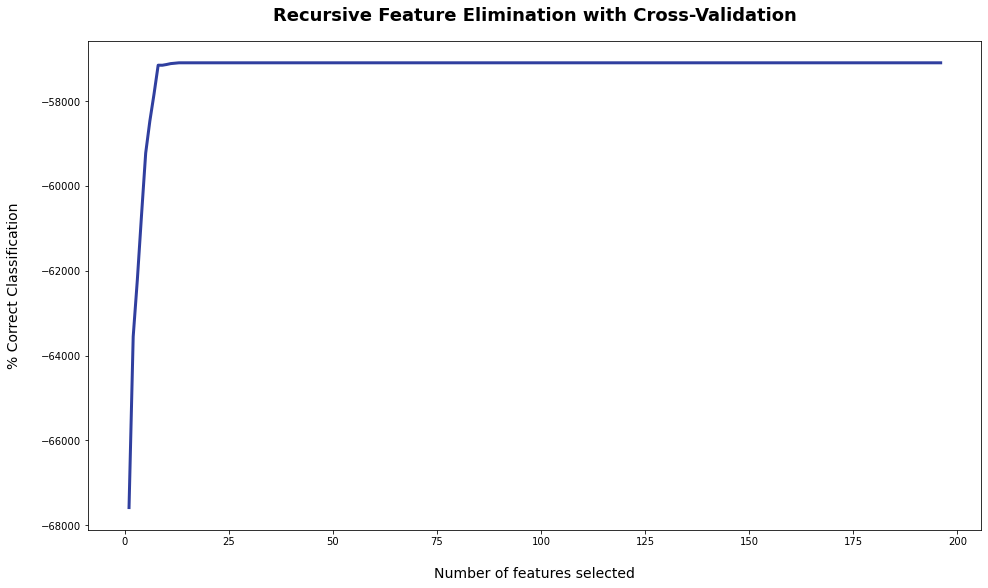

In [22]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

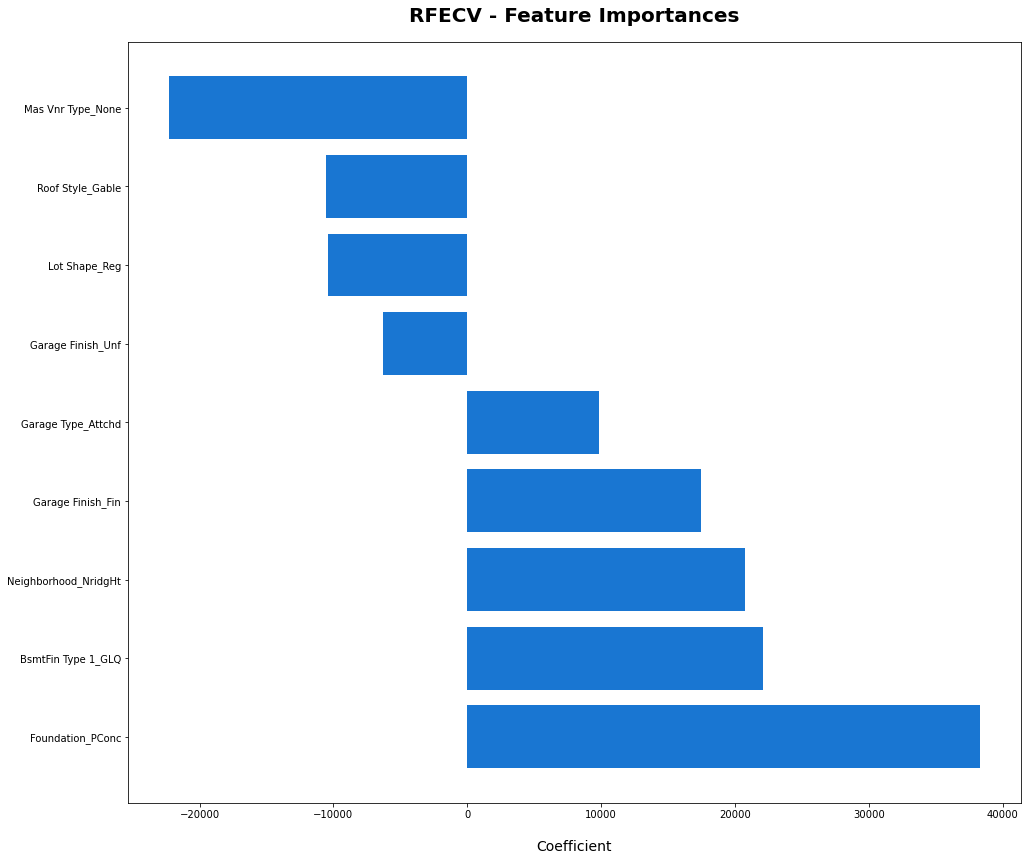

In [23]:
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset[dset['importance'] != 0]['attr'], width=dset[dset['importance'] != 0]['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Coefficient', fontsize=14, labelpad=20)
plt.show()

In [85]:
cat_col = set(dset[dset['importance'] != 0]['attr'].map(lambda x: x.split('_')[0]).unique().tolist())
cat_col = cat_col.union({'Bldg Type',
 'Foundation',
 'Street',
 'Central Air',
 'Electrical',
 'MS Zoning',
 'Land Contour',
 'Mas Vnr Type',
 'Heating',
 'Paved Drive',
 'Neighborhood'
          })

### Let's try with our model

In [98]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)
X_train = prep_poly(train,train)
y_train = train['SalePrice']

In [99]:
test = pd.read_csv('../datasets/test.csv')
test = cleaning_data(test)
test = feat_eng(test)
test = cat2num(test)
X_test = prep_poly(test,train)

In [100]:
#load pre-trained model

# ridge = load('ridge_regressor.joblib')
# lasso = load('lasso_regressor.joblib')
enet = load('enet_regressor.joblib')



#Elasticnet LR
# l1_ratio = np.linspace(0, 1, 11)
# l_alphas = np.arange(0.001, 1, 0.01)
# enet_cv = ElasticNetCV(alphas=l_alphas, l1_ratio=l1_ratio, max_iter=5000,cv=5)
# enet_cv.fit(X_train,y_train)

# enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=100000, warm_start=True)
#fit
enet.fit(X_train,y_train)


ElasticNet(alpha=0.06099999999999999, l1_ratio=0.0, max_iter=5000)

In [101]:
#RMSE on training set
print('ElasticNet Regression')
print(metrics.mean_squared_error(y_train,enet.predict(X_train),squared = False),'\n')

ElasticNet Regression
21164.308224555327 



In [102]:
#Cross Validation RMSE

enet_cv_score = cross_val_score(
    enet, X_train, y_train, scoring='neg_root_mean_squared_error',
    cv=5).mean() * -1

#Cross Validation RMSE
print('ElasticNet Regression')
print(enet_cv_score,'\n')

ElasticNet Regression
25616.224236958133 



Again, our ElasticNet model is taking the lead. I decided to finish fine tuning at this point.

### Making prediction and submit the result!

In [103]:
Poly_RFEonCat_prediction = enet.predict(X_test)
Poly_RFEonCat_submission = pd.DataFrame(Poly_RFEonCat_prediction,
                                   index=test.Id,
                                   columns=['SalePrice'])
Poly_RFEonCat_submission.to_csv('../Submission/Poly_RFEonCat_submission.csv')

## Model Evaluation

So far, we've experimented with different model and subset of features, here is a quick comparison of the result

|                                  Model                                  | RMSE on Training set | Cross val RMSE |
|:-----------------------------------------------------------------------:|:--------------------:|:--------------:|
| **Baseline**                                                               | 79229.31             | 79229.31       |
| **Hand-selected features**                                                  |                      |                |
| Linear Regression                                                       | 30873.96             | 1.12 e17       |
| Ridge Regression                                                        | 31040                | 32141.44       |
| Lasso Regression                                                        | 30860                | 32422.76       |
| ElasticNet Regression                                                   | 31064                | 32136.14       |
| **Polynomial of numerical features**                                        |                      |                |
| Linear Regression                                                       | 18987.03             | 29876.54      |
| Ridge Regression                                                        | 19774.57             | 25865.26      |
| Lasso Regression                                                        | 19026.74             | 29783.91       |
| ElasticNet Regression                                                   | 19881.52             | 25875.36       |
| **Polynomial of numerical features + addition categorical features by RFE** |                      |                |
| ElasticNet Regression                                                   | 21164.30            | 25616.22       |

- All of our model significantly surpassed the performance of baseline model (except multiple linear regression).
- After introducing polynomial degree = 2 to numerical attriubtes, the training error greatly reduce. The same trend was also be observed in cross validation RMSE. However it's a clear sign of overfitting, since the gap between training and cross validation RMSE is very huge.
- I selected an ElasticNet model with a polynomial degree = 2 to submit the prediction on test set.
- However it's extremely hard to be interpret, therefore the rest of interpretation will be based on ElasticNet on hand-selected features model


## Intrepetation

Due to the complexity of polynomial version of the model, it's a good practice for me try to understand relevant factor affecting the sale price of residential property by inferencing from simpler model. Therefore interpretation will be based on ElasticNet on hand-selected features.

In [121]:
train = pd.read_csv('../datasets/train.csv')
train = cleaning_data(train)
train = feat_eng(train)
train = cat2num(train)
X_train = prep(train,train)
y_train = train['SalePrice']

In [122]:
test = pd.read_csv('../datasets/test.csv')
test = cleaning_data(test)
test = feat_eng(test)
test = cat2num(test)
X_test = prep(test,train)

In [123]:
#load pre-trained model

# ridge = load('ridge_regressor.joblib')
# lasso = load('lasso_regressor.joblib')
enet = load('enet_regressor.joblib')



#Elasticnet LR
# l1_ratio = np.linspace(0, 1, 11)
# l_alphas = np.arange(0.001, 1, 0.01)
# enet_cv = ElasticNetCV(alphas=l_alphas, l1_ratio=l1_ratio, max_iter=5000,cv=5)
# enet_cv.fit(X_train,y_train)

# enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=100000, warm_start=True)
#fit
enet.fit(X_train,y_train)


ElasticNet(alpha=0.06099999999999999, l1_ratio=0.0, max_iter=5000)

In [124]:
summary = pd.DataFrame(index=X_train.columns)
# summary['feature'] = X_train.columns
summary['coef'] = enet.coef_

,coef
Mas Vnr Area,4281.095385
Kitchen Qual,6975.550113
Fireplaces,4249.367481
Bsmt Exposure,5741.252885
lot_frontage_imputed,-685.070403


Text(0.5, 1.02, 'Top 20 most positively & negatively impact on residential property price')

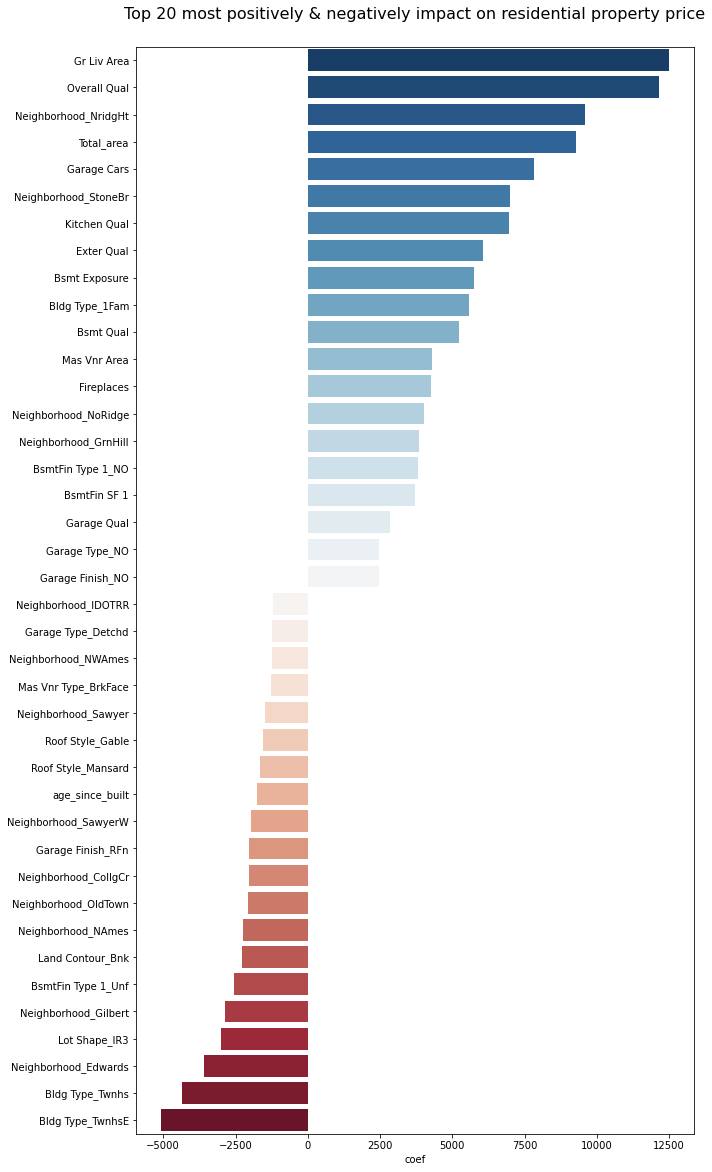

In [125]:
#Top and Bottom affecting feature
top_bot_20 = pd.concat([
    summary.sort_values(by='coef', ascending=False)[:20],
    summary.sort_values(by='coef', ascending=True)[:20]
],
                       axis=0)
top_bot_20 = top_bot_20.sort_values(by='coef',ascending=False)
top_bot_20

plt.figure(figsize = (10,20))
g = sns.barplot(data=top_bot_20,
            x='coef',
            y=top_bot_20.index,
           palette='RdBu_r')
g.set_title('Top 20 most positively & negatively impact on residential property price',y=1.02,fontsize=16)
g.set_xlabel('coeffici')


- As expected, overall quality and individual quality of each part of the property are the most contributing factors.
- The price of property vary differently in each neighborhood. Northridge Heights, Stone Brook are the most expensive, whereas Edwards and Gilbert are not very popular.
- In the aspect of building type, 1 Family house seems to positively impact the price, while twin house is opposite.

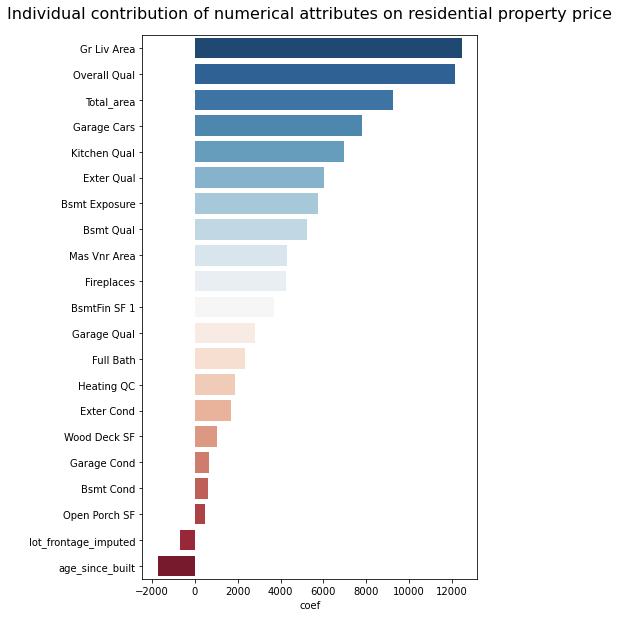

In [149]:
num_feat = summary.loc[num_col].sort_values(by='coef',ascending=False)
plt.figure(figsize = (6,10))
g = sns.barplot(data=num_feat,
            x='coef',
            y=num_feat.index,
           palette='RdBu_r')
g.set_title('Individual contribution of numerical attributes on residential property price',y=1.02,fontsize=16);

- Overall trend as describe in above figures,
- Lot frontage wasn't really important factor as I expected it to be, in fact people prefer property in long shape.
- The older the house was, the lower the price

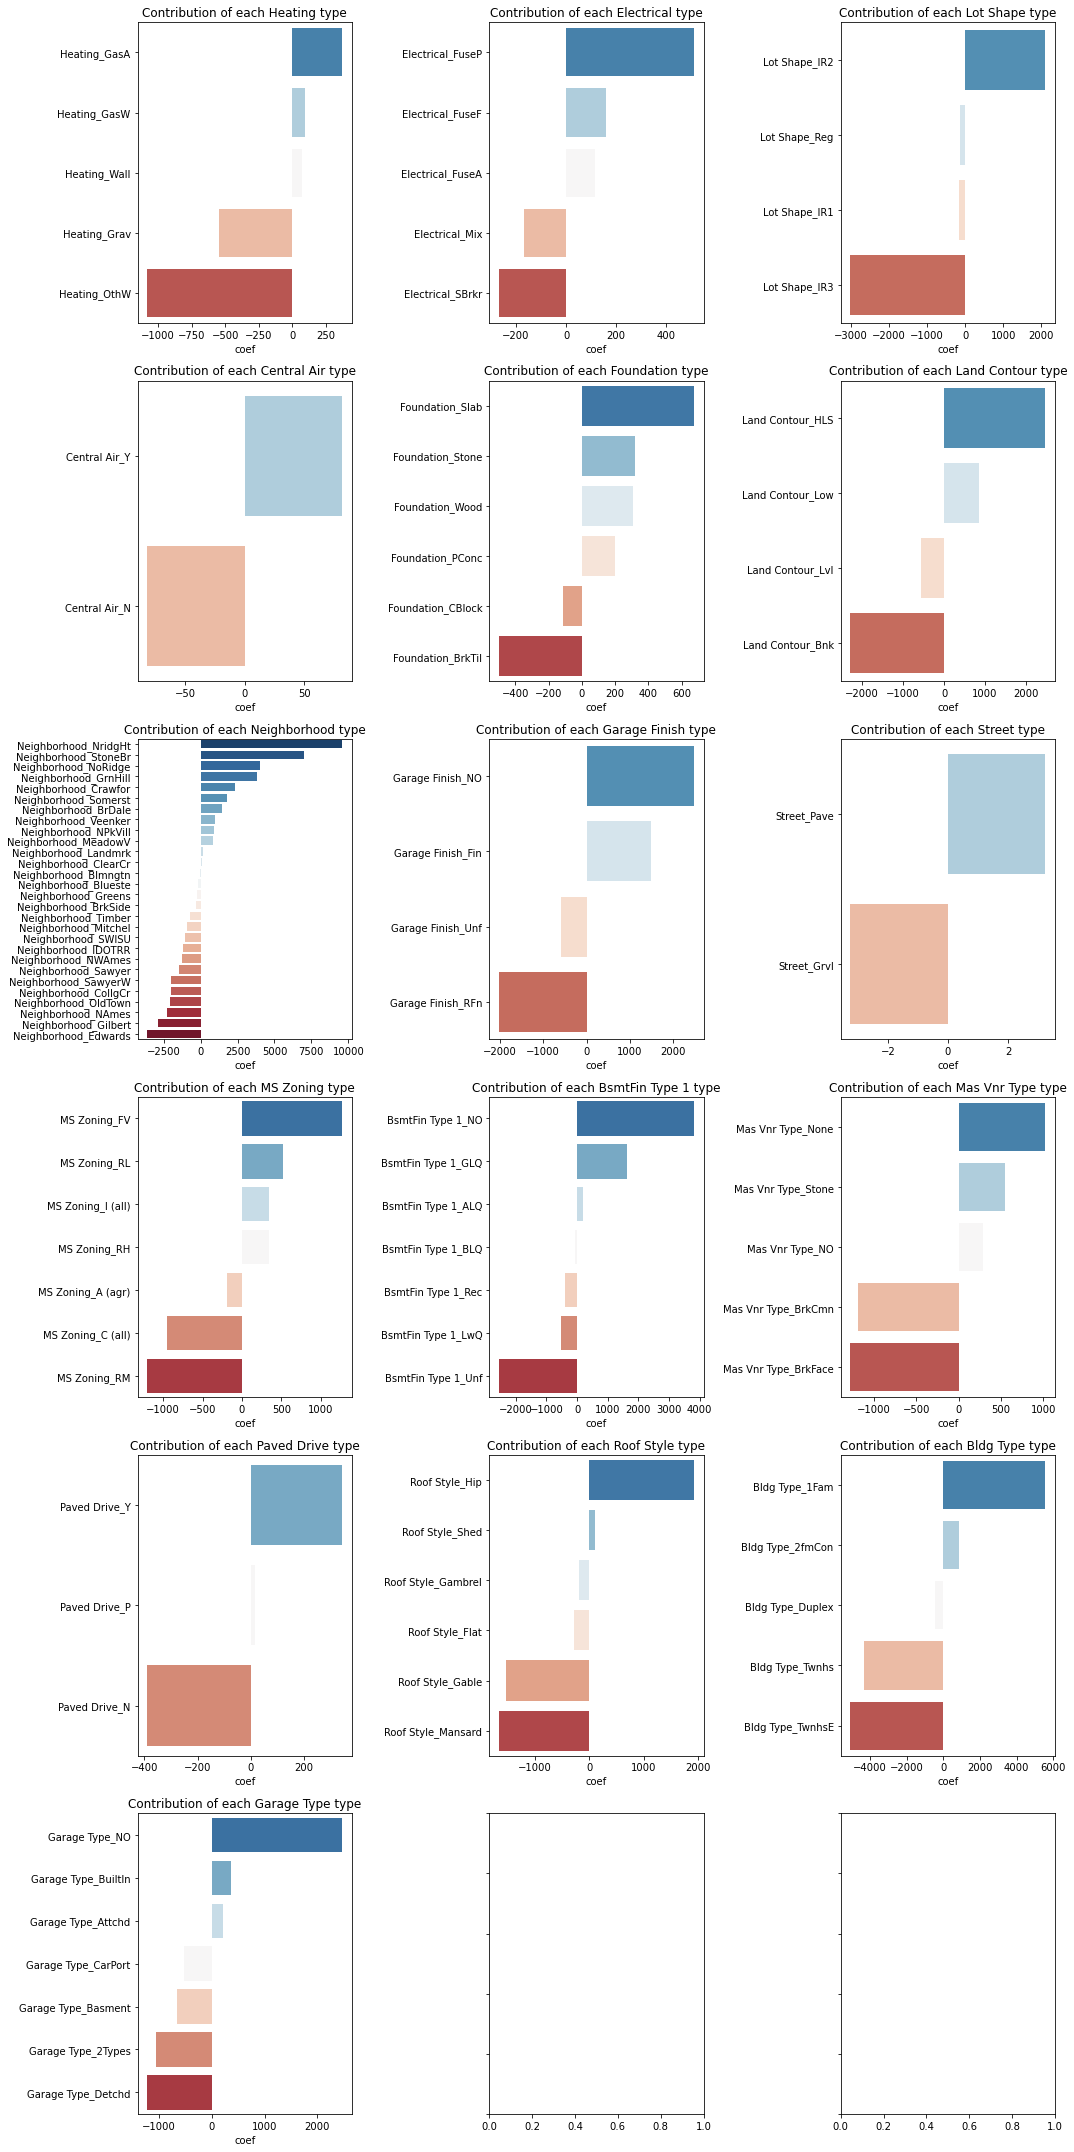

In [127]:
cat_col = list(cat_col)

#Initiate plot
fig = plt.subplots(len(cat_col) // 3 + 1, 3, figsize=(15, 30), sharey=True)


#loop through every categorical columns
for i, col in enumerate(cat_col, 1):
    plt.subplot(len(cat_col) // 3 + 1, 3, i)
    data = summary.loc[summary.index.str.contains(col+'_')].sort_values(by='coef', ascending = False)
    g = sns.barplot(data=data,
            x='coef',
            y=data.index,
           palette='RdBu_r')
    g.set_title('Contribution of each ' + col + ' type')

plt.tight_layout()

Among all models in our study, an ElasticNet regressor with polynomial has the best predictive performance (evaluated by RMSE). However, considering interpretability, the simpler version without polynomial transformation is much easier to interpet and be understood by non-technical user.

Although numerous factors impacted the property value, some of the factors worth mentioning are ...

- Although price tend to increase with the total area of the house, living area is the most expensive part of it.
- From the perspective of property reseller, while overall quality directly means high resell price, we could consider buying an average quality house and focus on renovation to boost its price.
- With a limited budget, focus on kitchen renovation and refurbishing external appearance by repainting.
- If there is no garage, don't waste your time building one. It won't add much value to the house.

### Limitation (Use with care)

- Our model doing well in property valuation in Ames area. However it might not be very accurate to be applied for data from other city or country.
- As a matter of fact, residential demand and preference vary in every single country due to the variety in cultures and social norm.
- The data is acquired between 2006 - 2010, hence it might not accurately refelct the present price.

### Improvement ideas

- taking in to account most updated data
- try in cluding some of important features when we are looking to buy a new house. For example in Thailand, 
    - proximity to infrastructure such as hospital, shopping mall, school, tollways, public transportation
    - number of nearby restaurants
    - Was it suffer from a flood?

## Reference

RFE : https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15